<h1>Прогнозирование объемов потребления электроэнергии<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Создание-базы-данных" data-toc-modified-id="Создание-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание базы данных</a></span><ul class="toc-item"><li><span><a href="#Сбор-данных-об-объемах-потребления" data-toc-modified-id="Сбор-данных-об-объемах-потребления-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сбор данных об объемах потребления</a></span></li><li><span><a href="#Сбор-данных-о-погоде" data-toc-modified-id="Сбор-данных-о-погоде-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сбор данных о погоде</a></span></li><li><span><a href="#Экспорт-итоговой-базы-данных" data-toc-modified-id="Экспорт-итоговой-базы-данных-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Экспорт итоговой базы данных</a></span></li></ul></li><li><span><a href="#Пополнение-базы-данных-оперативными-сведениями" data-toc-modified-id="Пополнение-базы-данных-оперативными-сведениями-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Пополнение базы данных оперативными сведениями</a></span></li><li><span><a href="#Подготовка-обучающего,-тестового-и-валидационного-фреймов" data-toc-modified-id="Подготовка-обучающего,-тестового-и-валидационного-фреймов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка обучающего, тестового и валидационного фреймов</a></span></li><li><span><a href="#Анализ-структуры-исходных-данных" data-toc-modified-id="Анализ-структуры-исходных-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ структуры исходных данных</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li><li><span><a href="#Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности" data-toc-modified-id="Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности</a></span><ul class="toc-item"><li><span><a href="#Оценка-(грубая)-модели-на-валидационных-данных" data-toc-modified-id="Оценка-(грубая)-модели-на-валидационных-данных-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Оценка (грубая) модели на валидационных данных</a></span></li></ul></li><li><span><a href="#Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона" data-toc-modified-id="Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Обучение с фильтрацией исходных признаков и временного диапазона</a></span><ul class="toc-item"><li><span><a href="#Оценка-модели-на-тестовых-данных-(2023-год)" data-toc-modified-id="Оценка-модели-на-тестовых-данных-(2023-год)-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Оценка модели на тестовых данных (2023 год)</a></span></li><li><span><a href="#Оценка-(грубая)-модели-на-валидационных-данных" data-toc-modified-id="Оценка-(грубая)-модели-на-валидационных-данных-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Оценка (грубая) модели на валидационных данных</a></span></li></ul></li><li><span><a href="#Посуточное-обучение-и-валидация" data-toc-modified-id="Посуточное-обучение-и-валидация-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Посуточное обучение и валидация</a></span></li></ul></li></ul></div>

**Исследуемый субъект:** республика Татарстан. Генеральная совокупность: 01.01.2013 – 01.06.2024, тестовая выборка: 2023 год (01.01.2023 – 31.12.2023), валидационная выборка: 01.06.2024 – 10.06.2024

# Используемые ресурсы

In [1]:
import os
import re
import locale
import requests
import warnings
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Создание базы данных
Запускается ежемесячно не позднее 7 числа после окончания расчётного периода для обновления БД<br>
Текущий интервал: 01.01.2013 – 01.06.2024

## Сбор данных об объемах потребления
Формирование базы данных из xls-файлов, предоставленных АО "Татэнергосыт" (*приложение 1*)

In [2]:
# получаем перечень всех папок из директории /_raw_Data_TatEnergosbyt
folders = list(folder for folder in os.listdir('_raw_Data_TatEnergosbyt'))

# получаем список месяцев на русском языке
locale.setlocale(locale.LC_TIME, 'ru_RU')
months = list(name.lower() for name in calendar.month_name if name != '')

# создаём датафрейм с данными об энергопотреблении
total_volume_df = pd.DataFrame()

# выгружаем данные из директории /_raw_Data_TatEnergosbyt
for folder in folders:
    for month in months:
                
        try:
            # получаем данные из единичного *.xls файла
            volume_df_raw = pd.read_excel(f'_raw_Data_TatEnergosbyt/{folder}/{month}.xls', index_col=0)

            # соединяем (горизонтально) две половины таблицы (верхнюю и нижнюю)
            volume_df_raw = pd.concat([volume_df_raw[6:6+24], volume_df_raw[-3-24:-3]], sort=False, axis=1)

            # удаляем "пустые" столбцы (заполненные NaN-ами)
            volume_df_raw.dropna(axis='columns', how='all', inplace=True)

            # в качестве имени столбцов назначаем порядковый номер дня месяца 
            volume_df_raw.columns = list(i for i in range(1, volume_df_raw.shape[1]+1))

            # сбрасываем индекс
            volume_df_raw.reset_index(drop=True, inplace=True)

            # создаём и заполняем фрагмент итоговой таблицы
            volume_df = pd.DataFrame(columns=['Date', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Volume'])     

            volume_df.Volume = np.array([value for name, value in volume_df_raw.items()]).ravel()
            volume_df.Volume = volume_df.Volume.astype(float)
            volume_df.Day = pd.Series(list(i for i in range(1, volume_df_raw.shape[1] + 1) for _ in range(24)))
            volume_df.Hour = pd.Series(list(i for i in range(1, 25)) * volume_df_raw.shape[1])        
            volume_df.Month = months.index(month) + 1
            volume_df.Year = int(folder[:-1])

            # добавляем категориальный признак "день недели"
            volume_df.Date = pd.to_datetime(volume_df[['Year', 'Month', 'Day', 'Hour']])
            volume_df.Hour = volume_df.Date.dt.hour  # унифицируем 24-й час под DataTime-объект
            volume_df.Weekday = volume_df.Date.dt.weekday

            # сшиваем полученный фрагмент с итоговой таблицей
            total_volume_df = pd.concat([total_volume_df, volume_df])
        
        except FileNotFoundError:  # отрабатываем ситуацию неполного года
            continue
            
total_volume_df.to_excel('Volume.xlsx', index=False)  # экспорт датафрейма в xlsx-файл

In [3]:
total_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100056 entries, 0 to 743
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     100056 non-null  datetime64[ns]
 1   Year     100056 non-null  int64         
 2   Month    100056 non-null  int64         
 3   Day      100056 non-null  int64         
 4   Hour     100056 non-null  int64         
 5   Weekday  100056 non-null  int64         
 6   Volume   100056 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 6.1 MB


In [4]:
total_volume_df

,Date,Year,Month,Day,Hour,Weekday,Volume
0,2013-01-01 01:00:00,2013,1,1,1,1,2033.264
1,2013-01-01 02:00:00,2013,1,1,2,1,1987.714
2,2013-01-01 03:00:00,2013,1,1,3,1,1955.861
3,2013-01-01 04:00:00,2013,1,1,4,1,1944.520
4,2013-01-01 05:00:00,2013,1,1,5,1,1964.332
...,...,...,...,...,...,...,...
739,2024-05-31 20:00:00,2024,5,31,20,4,2376.263
740,2024-05-31 21:00:00,2024,5,31,21,4,2396.689
741,2024-05-31 22:00:00,2024,5,31,22,4,2392.955
742,2024-05-31 23:00:00,2024,5,31,23,4,2268.094


## Сбор данных о погоде
Выгрузка базы данных о погоде в Татарстане с ноября 2010 года

In [5]:
# парсим данные из сайта kazan.nuipogoda.ru
links, data_of_weather = list(), list()

for month in months:
    req = requests.get(url=f'https://kazan.nuipogoda.ru/{month}-2013')
    soup = BeautifulSoup(req.content, 'lxml')
    all_tds = soup.find_all('td')
    for i in range(len(all_tds)):
        try:
            links.append('https://kazan.nuipogoda.ru/' + all_tds[i].find('a').get('href'))
        except AttributeError:
            continue

for link in links:
    req = requests.get(url=link)
    soup = BeautifulSoup(req.content)
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    for k in range(len(trs)):
        data_of_weather.append((list(trs[k].attrs.values())[0], trs[k].find('span', class_='ht').text[:-1]))

In [6]:
# Формируем датафрейм с погодными условиями
df_weather = pd.DataFrame(data_of_weather, columns=['Date', 'Temperature']).astype('int64')
df_weather.Date = pd.to_datetime(df_weather.Date, unit='ms')
df_weather = df_weather.drop_duplicates(subset=['Date'])
df_weather = df_weather.sort_values(by=['Date'])

df_weather.to_excel('Weather.xlsx', index=False)  # экспорт датафрейма в xlsx-файл

In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41276 entries, 38303 to 46285
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         41276 non-null  datetime64[ns]
 1   Temperature  41276 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 967.4 KB


In [8]:
df_weather

,Date,Temperature
38303,2010-11-01 00:00:00,-2
38304,2010-11-01 03:00:00,0
38305,2010-11-01 06:00:00,-1
38306,2010-11-01 09:00:00,-1
38307,2010-11-01 12:00:00,1
...,...,...
46281,2024-12-31 12:00:00,1
46282,2024-12-31 15:00:00,1
46283,2024-12-31 18:00:00,2
46284,2024-12-31 21:00:00,3


## Экспорт итоговой базы данных

In [9]:
# для работы с готовыми фреймами расскоментируйте строки ниже
#total_volume_df = pd.read_excel('Volume.xlsx')
#df_weather = pd.read_excel('Weather.xlsx')

In [10]:
# объединяем полученные датафреймы по дате
df = total_volume_df.merge(df_weather, how='left', on = 'Date')

# интерполируем пропуски температуры (линейная, полиноминальная 3 порядка)
df[['Temperature']] = df[['Temperature']].interpolate(method='polynomial', order=3).round(1)

# экстраполируем пропуск температуры для первой записи соседним значением
df[['Temperature']] = df[['Temperature']].interpolate(method='nearest', axis=0).ffill().bfill()

# сохраняем полученную базу данных в xlsx-файл
df.to_excel('DataBase.xlsx', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100056 entries, 0 to 100055
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         100056 non-null  datetime64[ns]
 1   Year         100056 non-null  int64         
 2   Month        100056 non-null  int64         
 3   Day          100056 non-null  int64         
 4   Hour         100056 non-null  int64         
 5   Weekday      100056 non-null  int64         
 6   Volume       100056 non-null  float64       
 7   Temperature  100056 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 6.9 MB


In [11]:
df

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature
0,2013-01-01 01:00:00,2013,1,1,1,1,2033.264,-8.0
1,2013-01-01 02:00:00,2013,1,1,2,1,1987.714,-8.0
2,2013-01-01 03:00:00,2013,1,1,3,1,1955.861,-7.6
3,2013-01-01 04:00:00,2013,1,1,4,1,1944.520,-7.6
4,2013-01-01 05:00:00,2013,1,1,5,1,1964.332,-8.0
...,...,...,...,...,...,...,...,...
100051,2024-05-31 20:00:00,2024,5,31,20,4,2376.263,19.0
100052,2024-05-31 21:00:00,2024,5,31,21,4,2396.689,18.0
100053,2024-05-31 22:00:00,2024,5,31,22,4,2392.955,17.2
100054,2024-05-31 23:00:00,2024,5,31,23,4,2268.094,16.6


# Пополнение базы данных оперативными сведениями

Cоздание пустого датафрейма (25 строк: с 0:00 до 24:00) на указанную дату

In [30]:
def get_empty_daily_df(date):
    return pd.DataFrame(pd.date_range(date, periods=25, freq='H'), columns=['Date'])
    
#get_empty_daily_df(datetime(2024,6,5))

Пополнение датафрейма дополнительными (временными) категориальными признаками

In [31]:
def add_date_scalar(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] =  df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Hour'] = df['Hour']
    df['Weekday'] = df.Date.dt.weekday
    return df

#add_date_scalar(test_df)

Выгрузка архива/прогноза погоды на указанную дату

In [32]:
def get_weather(date):
    
    months = ['', 'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 
              'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']  # названия месяцев в родительном падеже
    
    # выгружаем содержимое страницы https://kazan.nuipogoda.ru/ в переменную
    page = requests.get(url = f'https://kazan.nuipogoda.ru/{date.day}-{months[date.month]}#{date.year}')

    # сохраняем html-код страницы в переменную
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # фильтруем теги с температурой
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    
    # получаем "сырые" данные
    day_weather_df = list()
    
    for tr in trs:
        day_weather_df.append((list(tr.attrs.values())[0], tr.find('span', class_='ht').text[:-1]))
        
    # формируем интерпретируемый датафрейм
    day_weather_df = pd.DataFrame(day_weather_df, columns=['Date', 'Temperature']).astype('int64')
    day_weather_df.Date = pd.to_datetime(day_weather_df.Date, unit='ms')
    day_weather_df = day_weather_df.sort_values(by=['Date'])
    day_weather_df = day_weather_df.tail(9)
    
    # интерполируем пропуски температуры (полиноминальная 3 порядка) между 0, 3, 6, 9, 12, 15, 18, 21 и 24 часами
    day_weather_df = get_empty_daily_df(date).merge(day_weather_df, how='left', on='Date')
    day_weather_df.Temperature = day_weather_df.Temperature.interpolate(method='polynomial', order=3).round(1)    
    
    return day_weather_df.tail(24)  # возвращаем погодный датафрейм с 1:00 до 24:00

#get_weather(datetime(2024,6,9))

Получение оперативных данных из директории `/_raw_Data_TatEnergosbyt` (*приложение 2*)

In [35]:
# получаем перечень всех файлов с оперативными данными из директории /_raw_Data_TatEnergosbyt
files = list(file for file in os.listdir(f'_raw_Data_TatEnergosbyt') if 'xlsx' in file)

# формируем датафрейм из этих файлов
total_oper_df = pd.DataFrame()

for file in files:    
    # получаем данные из единичного xlsx-файла
    oper_df = pd.read_excel(f'_raw_Data_TatEnergosbyt/{file}')
    oper_df.drop(oper_df.columns[[0, 3, 4, 5]], axis=1, inplace=True)
    oper_df.columns = ['Date', 'Volume']
    oper_df = oper_df[5:]
    oper_df.Volume = oper_df.Volume.astype(float)
    oper_df.Date = oper_df.Date.astype('datetime64[ns]')
    oper_df.Date = oper_df.Date.dt.floor('h')  # убираем "мусорные" микросекунды
    
    # пополняем датафрейм погодными условиями
    oper_df = oper_df.merge(get_weather(oper_df.iloc[0].Date.floor('d')), how='left', on='Date')
        
    # пополняем датафрейм дополнительными категориальными признаками
    oper_df = add_date_scalar(oper_df)
    
    # сшиваем данные из единичных xlsx-файлов
    total_oper_df = pd.concat([total_oper_df, oper_df])
    
    # удаляем прочтённый xlsx-файл (во избежание дублирования строк в БД)
    os.remove(f'_raw_Data_TatEnergosbyt/{file}')
    
total_oper_df

,Date,Volume,Temperature,Year,Month,Day,Hour,Weekday
0,2024-06-01 01:00:00,2015.786000,14.7,2024,6,1,1,5
1,2024-06-01 02:00:00,1974.203000,14.4,2024,6,1,2,5
2,2024-06-01 03:00:00,1924.646000,15.0,2024,6,1,3,5
3,2024-06-01 04:00:00,1888.457000,16.1,2024,6,1,4,5
4,2024-06-01 05:00:00,1893.005000,17.5,2024,6,1,5,5
...,...,...,...,...,...,...,...,...
19,2024-06-09 20:00:00,2272.555436,21.8,2024,6,9,20,6
20,2024-06-09 21:00:00,2312.999271,20.0,2024,6,9,21,6
21,2024-06-09 22:00:00,2328.215377,18.2,2024,6,9,22,6
22,2024-06-09 23:00:00,2213.078977,16.7,2024,6,9,23,6


In [36]:
if total_oper_df.shape[0]:    
    
    # добавляем полученные данные к общей базе
    df = pd.read_excel('DataBase.xlsx')
    df = pd.concat([df, total_oper_df])

    # обновляем xlsx-файл с БД
    df.to_excel('DataBase.xlsx', index=False)

# Подготовка обучающего, тестового и валидационного фреймов

In [38]:
# для работы с готовой БД раскомментируйте строку ниже 
#df = pd.read_excel('DataBase.xlsx')

In [39]:
def prepareData(df, lag_start, lag_end):        
    
    # добавляем суточные лаги исходного ряда
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(i*24)   
        
    # удаляем первые 168 (7 * 24) записей с пропусками данных
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    
    return df

In [40]:
# формируем генеральную совокупность
df_general = df.copy()

# добавляем новые признаки
df_general = prepareData(df_general, 1, 7)

# формируем тестовую выборку (-1 год от текущих суток)
df_test = df_general[df_general.Date > datetime.now().replace(year=datetime.now().year-1, hour = 0)]
df_test.reset_index(drop=True, inplace=True)
df_test

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2023-06-10 01:00:00,2023,6,10,1,5,2020.717000,14.2,1997.464000,1993.795000,1988.079000,1953.444000,1934.511000,1962.836000,2031.941
1,2023-06-10 02:00:00,2023,6,10,2,5,1962.941000,13.0,1944.533000,1948.004000,1944.091000,1909.385000,1893.857000,1905.329000,1980.007
2,2023-06-10 03:00:00,2023,6,10,3,5,1907.557000,12.0,1898.582000,1897.986000,1888.169000,1861.565000,1845.076000,1852.913000,1934.509
3,2023-06-10 04:00:00,2023,6,10,4,5,1868.590000,11.9,1854.347000,1857.424000,1849.681000,1829.860000,1800.045000,1830.850000,1893.473
4,2023-06-10 05:00:00,2023,6,10,5,5,1879.977000,12.3,1883.808000,1888.589000,1863.993000,1859.972000,1826.282000,1842.475000,1882.126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-06-09 20:00:00,2024,6,9,20,6,2272.555436,21.8,2271.011250,2386.182736,2421.378673,2415.583867,2401.514952,2467.779016,2334.364
8780,2024-06-09 21:00:00,2024,6,9,21,6,2312.999271,20.0,2286.499684,2394.617812,2430.455592,2436.232011,2412.605402,2469.398816,2354.693
8781,2024-06-09 22:00:00,2024,6,9,22,6,2328.215377,18.2,2302.465685,2420.358483,2438.924052,2430.614426,2416.142478,2490.485832,2366.600
8782,2024-06-09 23:00:00,2024,6,9,23,6,2213.078977,16.7,2199.071768,2296.690451,2302.028551,2270.017769,2274.016779,2343.036600,2239.832


ПРОДУМАТЬ ЭТОТ БЛОК
* выделяем пустой фрейм
* соединяем с генеральной совокупностью
* выполняем препроцессинг
* отделяем прогнозную выборку
* "чистим" генеральный датафрейм

In [219]:
# формируем валидационную выборку (с 01.01.2024)
df_validate = df_general[df_general['Year'] == datetime.now().year]
df_validate.reset_index(drop=True, inplace=True)

# исключаем валидационную выборку из генеральной совокупности
df_general = pd.concat([df_general, df_validate]).drop_duplicates(keep=False)

In [41]:
df_general

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013-01-08 01:00:00,2013,1,8,1,1,2017.102000,-6.1,1983.630000,1984.007000,2000.216000,1972.473000,2008.811000,2027.193000,2033.264
1,2013-01-08 02:00:00,2013,1,8,2,1,1964.942000,-6.0,1932.213000,1934.204000,1950.523000,1920.304000,1953.228000,1970.887000,1987.714
2,2013-01-08 03:00:00,2013,1,8,3,1,1938.221000,-6.0,1904.510000,1907.831000,1920.106000,1889.606000,1915.720000,1938.669000,1955.861
3,2013-01-08 04:00:00,2013,1,8,4,1,1929.957000,-6.0,1895.918000,1897.508000,1915.331000,1882.192000,1904.349000,1931.414000,1944.520
4,2013-01-08 05:00:00,2013,1,8,5,1,1950.473000,-6.0,1921.034000,1904.977000,1922.729000,1902.160000,1905.641000,1939.466000,1964.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100099,2024-06-09 20:00:00,2024,6,9,20,6,2272.555436,21.8,2271.011250,2386.182736,2421.378673,2415.583867,2401.514952,2467.779016,2334.364
100100,2024-06-09 21:00:00,2024,6,9,21,6,2312.999271,20.0,2286.499684,2394.617812,2430.455592,2436.232011,2412.605402,2469.398816,2354.693
100101,2024-06-09 22:00:00,2024,6,9,22,6,2328.215377,18.2,2302.465685,2420.358483,2438.924052,2430.614426,2416.142478,2490.485832,2366.600
100102,2024-06-09 23:00:00,2024,6,9,23,6,2213.078977,16.7,2199.071768,2296.690451,2302.028551,2270.017769,2274.016779,2343.036600,2239.832


In [226]:
df_validate

,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2024,1,1,1,0,2464.374,-9.0,2467.182000,2500.409000,2516.290000,2503.312000,2494.054000,2497.371,2541.558
1,2024,1,1,2,0,2413.849,-10.1,2414.927000,2453.154000,2466.291000,2449.390000,2453.670000,2454.793,2487.862
2,2024,1,1,3,0,2352.794,-11.0,2388.927000,2424.264000,2439.137000,2424.754000,2428.197000,2424.492,2463.207
3,2024,1,1,4,0,2298.086,-10.9,2363.674000,2409.517000,2425.860000,2409.024000,2426.159000,2408.522,2447.075
4,2024,1,1,5,0,2281.267,-10.3,2366.648000,2429.743000,2459.253000,2438.181000,2448.773000,2446.638,2463.883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2024,5,27,20,0,2345.000,14.3,2340.629654,2347.681582,2348.097925,2376.526240,2310.098662,2347.244,2352.341
3548,2024,5,27,21,0,2403.000,12.0,2397.352736,2407.262749,2416.818505,2443.232621,2375.552849,2409.083,2425.386
3549,2024,5,27,22,0,2418.000,12.0,2396.253282,2385.038212,2416.577706,2451.671512,2362.303595,2387.572,2418.587
3550,2024,5,27,23,0,2272.000,12.0,2254.881029,2259.527937,2294.175647,2309.607195,2218.803103,2243.966,2268.875


# Анализ структуры исходных данных

*График структуры (усредненной по дням недели) потребления электрической энергии за 10 лет*

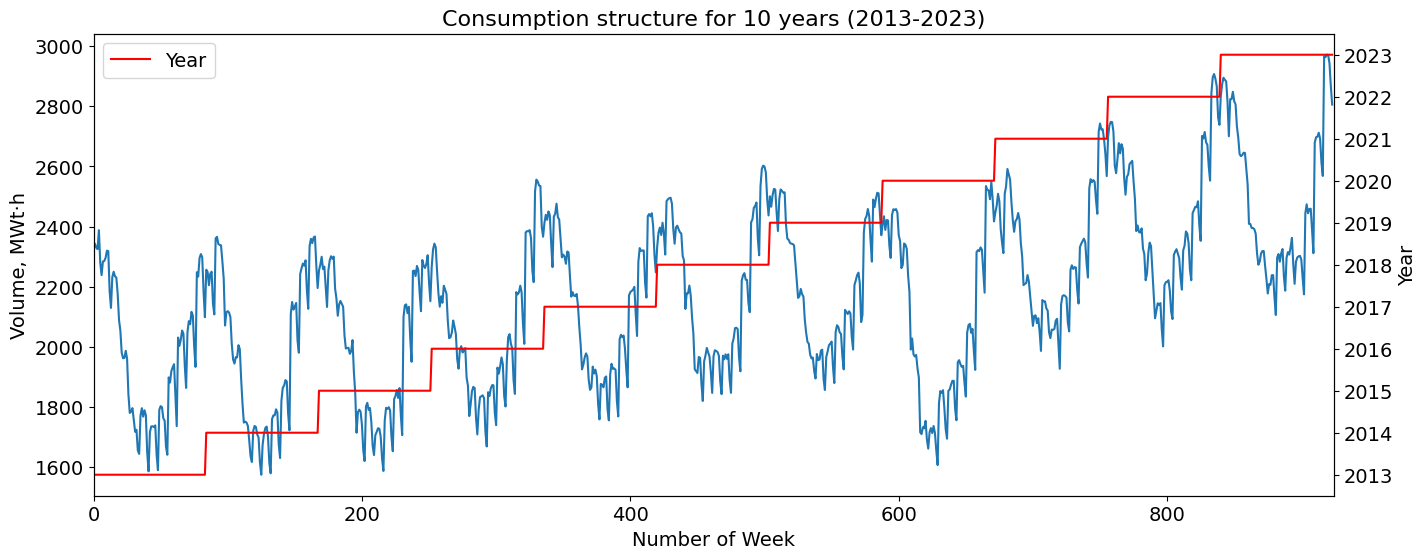

In [231]:
df_general_group = df_general.groupby(['Year', 'Month', 'Weekday'])[['Volume']].mean()
df_general_group.reset_index(inplace=True)
#df_general_group = df_general.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,6))
df_year = df_volume.twinx()

df_volume.plot(df_general_group['Volume'], label='Volume')
df_year.plot(df_general_group['Year'], label='Year', color='red')

plt.rcParams['font.size'] = '14'

df_volume.set_xlim(0, df_general_group.shape[0])
#df_volume.set_ylim(df_general_group['Volume'].min(), df_general_group['Volume'].max())  # диапазон 'volume' от min до max
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Week', fontsize = 14)
df_year.set_ylabel('Year', fontsize = 14)
df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

plt.title(f'Сonsumption structure for 10 years (2013-{datetime.now().year-1})', fontsize = 16)
plt.legend()

*График структуры (усредненной по дням) потребления электрической энергии за 2023 год*

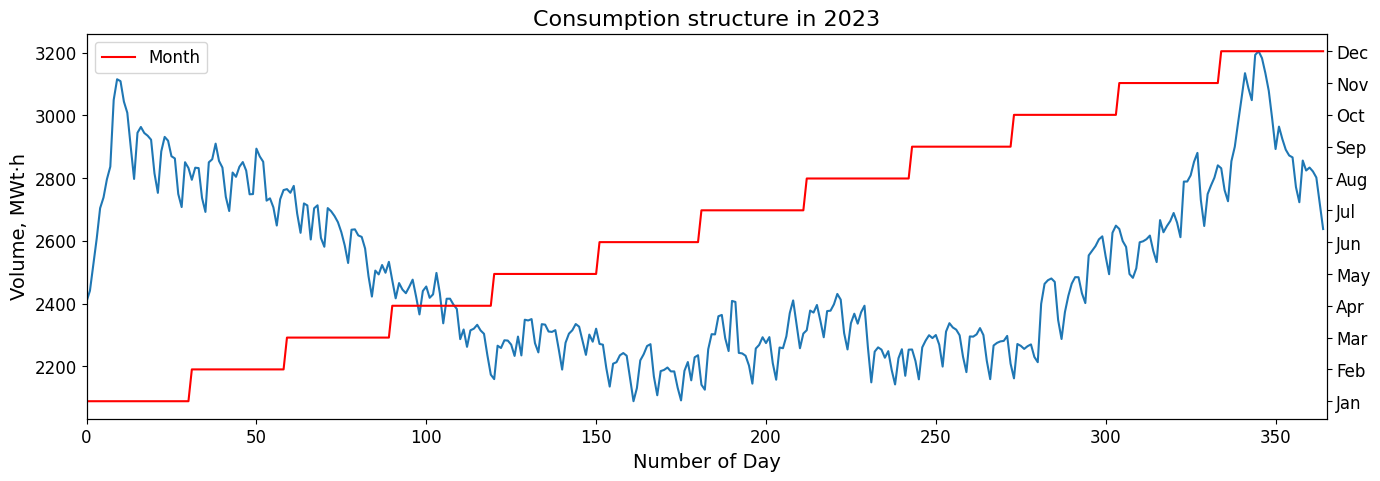

In [238]:
locale.setlocale(locale.LC_TIME, 'en_EN')

df_last_year = df_general[df_general['Year'] == datetime.now().year - 1]
df_last_year.reset_index(drop=True, inplace=True)

df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume']].mean()
df_group_last_year.reset_index(inplace=True)
#df_group_last_year = df_last_year.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,5))
df_month = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], label='Volume')
df_month.plot(df_group_last_year['Month'], label='Month', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Day', fontsize = 14)
df_month.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 13)]))
df_month.yaxis.set_major_formatter(ticker.FixedFormatter(list(name for name in calendar.month_abbr if name != '')))

plt.title(f'Сonsumption structure in {datetime.now().year-1}', fontsize = 16)
plt.legend()

*График зависимости усреднённой по дням температуры с усреднённым по дням потреблением ЭЭ для 2023 года*

Text(0.5, 1.0, 'Graph of average daily consumption and average daily temperature for 2023')

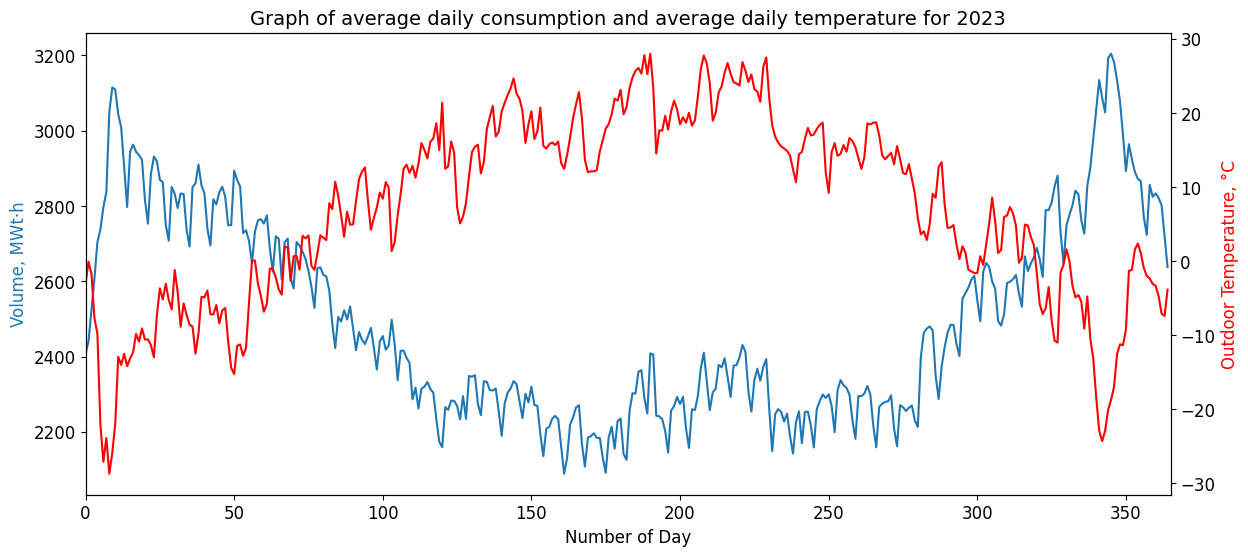

In [239]:
df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume', 'Temperature']].mean()
df_group_last_year.reset_index(drop=True, inplace=True) 

fig, df_volume = plt.subplots(figsize=(14,6))
df_temperature = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], color='#1f77b4', label='Volume')

df_temperature.plot(df_group_last_year['Temperature'], color = 'red', label = 'Temperature')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 12, color='#1f77b4')
df_volume.set_xlabel('Number of Day', fontsize = 12)
df_temperature.set_ylabel('Outdoor Temperature, °C', fontsize = 12, color='red')

plt.title(f'Graph of average daily consumption and average daily temperature for {datetime.now().year-1}', fontsize = 14)

**Вывод**: Наблюдается отчетливая корреляция между температурой наружного воздуха и объемом электропотребления

*График структуры потребления электрической энергии по дням недели в течении месяца*

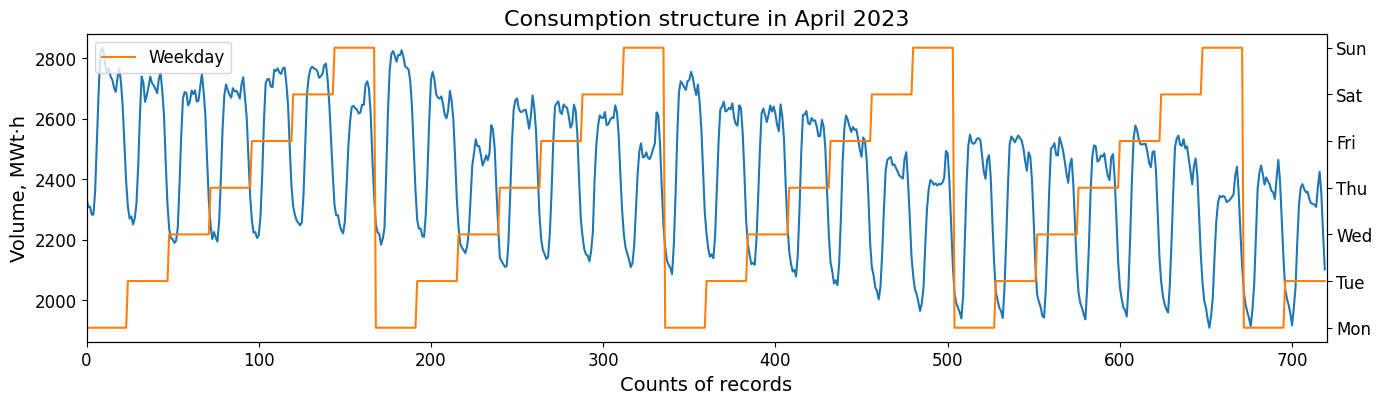

In [243]:
month = list(name for name in calendar.month_name)

df_month = df_validate[df_validate['Month'] == 4]  # указываем интересующий нас месяц
df_month.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_weekday = df_volume.twinx()

df_volume.plot(df_month['Volume'], label='Volume')
df_weekday.plot(df_month['Weekday'], label='Weekday', color='#ff7f0e')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_month.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

plt.title(f'Сonsumption structure in {month[df_month.Month[0]]} {datetime.now().year-1}', fontsize = 16)
plt.legend()

*Корреляция числовых и категориальных признаков*

[Text(0.5, 1.0, 'Correlation matrix of initial features')]

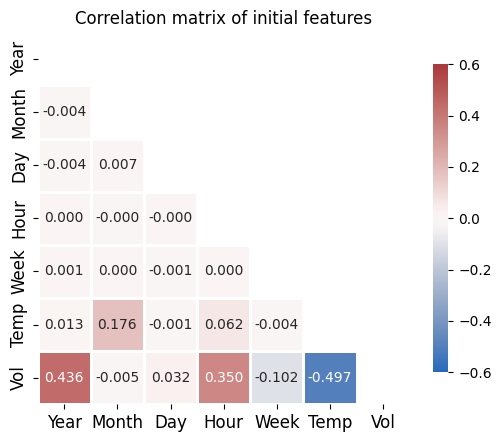

In [245]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df_gen = df_general[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature', 'Volume']]
df_gen = df_gen.rename(columns={'Weekday': 'Week', 'Temperature': 'Temp', 'Volume': 'Vol'})

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_gen.corr(), dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

plt.rcParams.update({'font.size': 10, 'font.serif': 'Times New Roman'})

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_gen.corr(), annot=True, mask=mask, cmap=color_map, fmt=".3f", vmax=.6, vmin=-0.6, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}).set(title='Correlation matrix of initial features')

#print(plt.rcParams)  # полный перечень всех настроек plt.rcParams
#df_gen.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)  # вывод в форме компактной таблицы

**Вывод**: ощутимая корреляционная связь объема с годом, часом и температурой

# XGBoost

## Оценка ценности признаков

In [246]:
# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df_general.drop(columns='Volume'), df_general['Volume'])

features_table = pd.DataFrame(result.feature_importances_, 
                              index = df_general.drop(columns='Volume').columns, 
                              columns = ['importance'])

features_table = features_table.sort_values(by='importance', ascending=False).T
features_table

,lag-1,lag-7,Weekday,lag-3,lag-6,Month,Hour,Temperature,lag-4,Day,Year,lag-5,lag-2
importance,0.742147,0.205954,0.017641,0.006499,0.004689,0.004513,0.004198,0.003698,0.003532,0.002573,0.00221,0.001412,0.000934


In [247]:
# исследуемый список датасетов с учетом ценности признаков
dataset = list([df_general.drop(columns='Volume').columns,
                df_general.drop(columns=['Hour', 'Volume']).columns,
                df_general.drop(columns=['Hour', 'Year', 'Volume']).columns])

predictions = list(['Predicted',  # скорректировать список под новые данные при изменении ценности признаков
                    'Predicted_1c', 
                    'Predicted_2c'])

messages = list([f'Full set:',
                 f'Without {features_table.columns[-1]}',
                 f'Without {features_table.columns[-1]} & {features_table.columns[-2]}'])

## Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности
Обучение выполняется по методике, описанной в [статье](https://www.mdpi.com/2411-5134/8/5/114): валидация 1 к 3, количество деревьев `n_estimators` – 100, генеральная совокупность данных – за 3 года

In [248]:
%%time

# поиск лучших гиперпараметров XGBoost с помощью сетки гиперпараметров
df_boost_train = df_general[df_general['Year'] > 2020]  # формируем обучающий датафрейм
df_boost_test = df_test.copy()

XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 10)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

XGB_best = XGB_search.best_estimator_

XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

# Предсказываем объемы потребления
df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

hyper_params = XGB_best.get_params()
print(f"max_depth: {hyper_params['max_depth']}, n_estimators: {hyper_params['n_estimators']}")

print()

MAE: 28.09 [MW] 
MAPE: 1.13%
max_depth: 3, n_estimators: 100

CPU times: total: 36.6 s
Wall time: 12.3 s


### Оценка (грубая) модели на валидационных данных

In [249]:
# Грубая валидация без сокрытия данных на текущие сутки (для скоростной проверки гипотезы)

df_boost_test = df_validate.copy()

df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

#df_boost_test

MAE: 41.16 [MW] 
MAPE: 1.55%


## Обучение с фильтрацией исходных признаков и временного диапазона

In [265]:
%%time

# инициализируем итоговый датафрейм по всем временным интервалам (3-11 лет)
df_general_result = pd.DataFrame({'period':[],  # рассматриваемый временной интервал
                                  'set': [],  # тип датасета
                                  'MAE [MW]':[],  # минимальная средняя абсолютная ошибка
                                  'MAPE':[],  # минимальная средняя относительная ошибка
                                  'max_depth':[],  # оптимальная глубина дерева
                                  'n_estimators':[]})  # оптимальное количество деревьев

index = 0  # индекс узла сетки итогового датафрейма

df_boost_test = df_test.copy()

for time in trange(2021, 2012, -1, desc=f"period progress"):  # виджет процесса расчёта оптимальных гиперпараметров

    df_boost_train = df_general[df_general['Year'] >= time]  # формируем обучающий датафрейм под рассматриваемый интервал

    for data in range(len(dataset)):  # выбор датасета

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 6)}, 
                          scoring='neg_mean_absolute_percentage_error',
                          verbose = 0,
                          cv=5)

        XGB_search.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)
        
        df_boost_test[predictions[data]] = XGB_best.predict(df_boost_test[dataset[data]])
        
        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time, messages[data], 
                                        MAE(df_boost_test[predictions[data]], df_boost_test['Volume']), 
                                        MAPE(df_boost_test[predictions[data]], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

#print()

period progress:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 14min 29s
Wall time: 3min 20s


*Полученная комбинация оптимальных гиперпараметров при различной глубине временного интервала заданных датасетов*

In [267]:
i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
            'index': messages.index(df_general_result.set[i]),  # индекс оптимального датасета
            'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
            'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

print(best_HP)

df_general_result.style.highlight_min(color='yellowgreen', subset='MAPE')

{'period': 7, 'index': 0, 'max_depth': 5, 'n_estimators': 100}


,period,set,MAE [MW],MAPE,max_depth,n_estimators
0,3,Full set:,28.088164,0.011332,3,100
1,3,Without lag-2,23.362514,0.009503,5,100
2,3,Without lag-2 & lag-5,24.467768,0.009967,5,100
3,4,Full set:,25.058846,0.010132,4,100
4,4,Without lag-2,29.293220,0.011867,4,100
5,4,Without lag-2 & lag-5,26.237536,0.010722,5,100
6,5,Full set:,25.968059,0.010466,4,100
7,5,Without lag-2,30.915765,0.012459,4,100
8,5,Without lag-2 & lag-5,27.142897,0.011091,5,100
9,6,Full set:,26.317896,0.010582,4,100


In [283]:
# ручная донастройка гиперпараметров
best_HP = {'period': 7,   # оптимальный временной период
            'index': 0,  # индекс оптимального датасета
            'max_depth': 5,   # отпимальная глубина дерева
            'n_estimators': 100}  # оптимальное колличество деревьев

*Предельные показатели метрики MAPE при различной глубине исследуемого интервала*

{'period': 7, 'index': 0, 'max_depth': 5, 'n_estimators': 100}


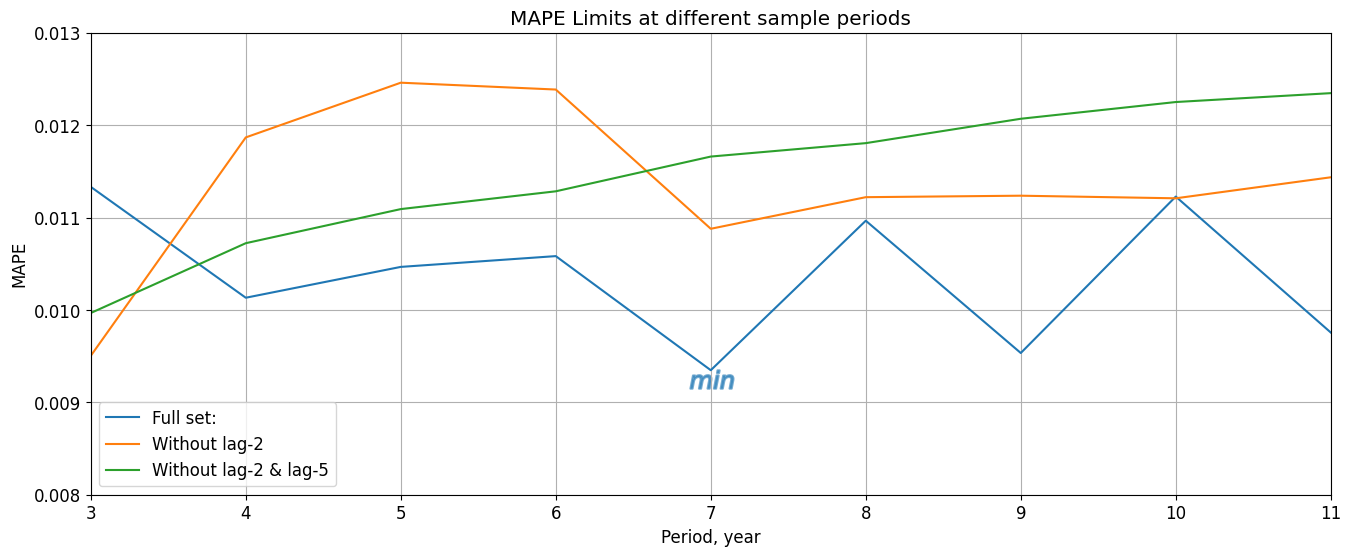

In [268]:
plot_gen = list()
for i in range(len(messages)):
    plot_gen.append(df_general_result[df_general_result['set'] == messages[i]])
    plot_gen[i]=plot_gen[i][['period', 'MAPE']]
    plot_gen[i].set_index('period', inplace= True)
    plot_gen[i] = plot_gen[i].rename(columns={'MAPE': messages[i]})

pd.concat([plot_gen[i] for i in range(3)], axis=1).plot(figsize=(16,6), 
                                                        title='MAPE Limits at different sample periods',
                                                        xlim=(df_general_result.period.min(), 
                                                              df_general_result.period.max()), 
                                                        ylim=(round(df_general_result.MAPE.min(), 3) - 0.001, 
                                                              round(df_general_result.MAPE.max(), 3) + 0.001),
                                                        xlabel='Period, year',
                                                        ylabel='MAPE',
                                                        legend=True,
                                                        grid=True)
plt.rcParams['font.size'] = '12'

plt.scatter(df_general_result.period[df_general_result.MAPE.idxmin()], 
            df_general_result.MAPE.min()-0.0001,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

print(best_HP)

**Выводы**: 
1. Фильтрация исходных признаков лишено всякого смысла
2. Оптимальный размер обучающей выборки: 5-6 лет
3. Оптимальная глубина дерева: 2-6 веток

### Оценка модели на тестовых данных (2023 год)

*Оценка прогнозирования за 2023 год при оптимальных гиперпараметрах с разбивкой по месяцам*

In [284]:
%%time

df_boost_test = df_test.copy()  # формируем тестовый датафрейм
df_boost_train = df_general[df_general['Year'] > datetime.now().year - best_HP['period'] - 1]  # формируем обучающий датафрейм

# обучаем модель
model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                         n_estimators = best_HP['n_estimators'],
                         max_depth = best_HP['max_depth'])

model.fit(df_boost_train[dataset[best_HP['index']]], df_boost_train['Volume'])
df_boost_test[predictions[best_HP['index']]] = model.predict(df_boost_test[dataset[best_HP['index']]])

CPU times: total: 1.44 s
Wall time: 432 ms


In [285]:
month = list(name for name in calendar.month_name)

df_month_result = pd.DataFrame({'Month':[],
                                'MAE [MW]':[],
                                'MAPE':[]})

for i in range(12):
    df_month = df_boost_test[df_boost_test['Month'] == i + 1]
    if df_month.shape[0]:
        df_month_result.loc[i] = (month[i + 1],
                                  f"{MAE(df_month[predictions[best_HP['index']]], df_month['Volume']):.2f}", 
                                  f"{MAPE(df_month[predictions[best_HP['index']]], df_month['Volume']):.3%}")

df_month_result = pd.concat([df_month_result, 
                             pd.DataFrame({'Month': 'Average', 
                                           'MAE [MW]': f"{MAE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.2f}", 
                                           'MAPE': f"{MAPE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.3%}"}, 
                             index = [0])])

df_month_result.set_index('Month').T

Month,January,February,March,April,May,June,July,August,September,October,November,December,Average
MAE [MW],22.78,25.74,22.55,21.92,28.85,25.66,22.45,23.06,18.37,19.38,25.44,20.92,23.07
MAPE,0.814%,0.918%,0.855%,0.916%,1.266%,1.155%,0.991%,1.003%,0.811%,0.813%,0.959%,0.718%,0.935%


### Оценка (грубая) модели на валидационных данных

In [286]:
# Предсказываем объемы потребления на валидационной выборке
df_validate_boost = df_validate.copy()

df_validate_boost[predictions[best_HP['index']]] = model.predict(df_validate_boost[dataset[best_HP['index']]])

# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2%}")

df_validate_boost

MAE: 39.31 [MW] 
MAPE: 1.48%


,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,Predicted
0,2024,1,1,1,0,2464.374,-9.0,2467.182000,2500.409000,2516.290000,2503.312000,2494.054000,2497.371,2541.558,2365.985840
1,2024,1,1,2,0,2413.849,-10.1,2414.927000,2453.154000,2466.291000,2449.390000,2453.670000,2454.793,2487.862,2372.788574
2,2024,1,1,3,0,2352.794,-11.0,2388.927000,2424.264000,2439.137000,2424.754000,2428.197000,2424.492,2463.207,2359.126709
3,2024,1,1,4,0,2298.086,-10.9,2363.674000,2409.517000,2425.860000,2409.024000,2426.159000,2408.522,2447.075,2342.496582
4,2024,1,1,5,0,2281.267,-10.3,2366.648000,2429.743000,2459.253000,2438.181000,2448.773000,2446.638,2463.883,2344.345459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2024,5,27,20,0,2345.000,14.3,2340.629654,2347.681582,2348.097925,2376.526240,2310.098662,2347.244,2352.341,2363.832764
3548,2024,5,27,21,0,2403.000,12.0,2397.352736,2407.262749,2416.818505,2443.232621,2375.552849,2409.083,2425.386,2411.861328
3549,2024,5,27,22,0,2418.000,12.0,2396.253282,2385.038212,2416.577706,2451.671512,2362.303595,2387.572,2418.587,2385.210449
3550,2024,5,27,23,0,2272.000,12.0,2254.881029,2259.527937,2294.175647,2309.607195,2218.803103,2243.966,2268.875,2262.191650


*Сравнение прогнозных значений с фактическими*

February 2024 MAPE: 1.126%


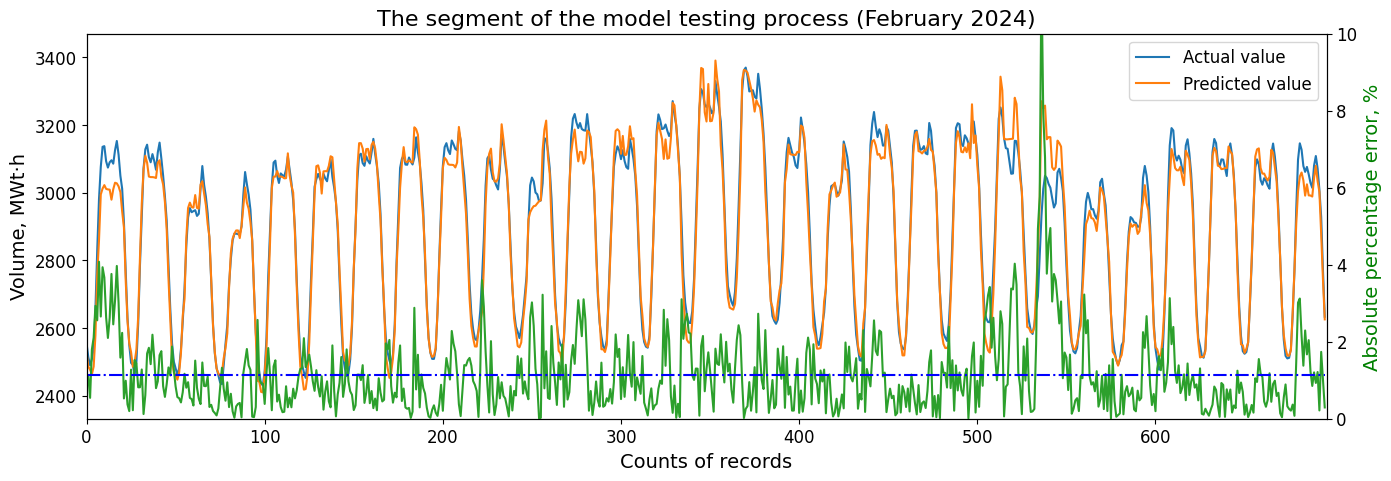

In [307]:
# приводим название столбца Prediction для фильтрованных данных к общему виду
df_validate_boost = df_validate_boost.rename(columns={predictions[best_HP['index']]:'Predicted'})

def diff_predict_vs_fact(df_validate_boost, num_month):
    
    df_validate_graph = df_validate_boost[df_validate_boost['Month'] == num_month].copy()

    # добавление новых столбцов (для расчёта усреднённой погрешности)
    df_validate_graph.insert(df_validate_graph.shape[1], 'MAPE', 
                             MAPE(df_validate_graph['Predicted'], df_validate_graph['Volume'])*100)

    df_validate_graph['Error'] = abs((df_validate_graph['Volume'] - df_validate_graph['Predicted'])*100
                                 /df_validate_graph['Volume'])

    df_validate_graph.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate_graph['Volume'], label='Actual value')
    df_volume.plot(df_validate_graph['Predicted'], label='Predicted value')
    df_error.plot(df_validate_graph['Error'], label='Error, %', color='#2ca02c')
    df_error.plot(df_validate_graph['MAPE'], '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate_graph.shape[0])
    df_volume.set_ylim(df_validate_graph.Volume.min() - 100, df_validate_graph.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    plt.title(f'The segment of the model testing process ({month[df_validate_graph.Month[0]]} {datetime.now().year})', 
              fontsize = 16)
    print(f"{month[df_validate_graph.Month[0]]} {datetime.now().year} MAPE: {round(df_validate_graph['MAPE'].iloc[0], 3)}%")
    
#diff_predict_vs_fact(df_validate_boost, 1)
diff_predict_vs_fact(df_validate_boost, 2)

## Посуточное обучение и валидация
*Прогнозирование на сутки вперед: данные доступны до 11:00 AM минус первых суток* 

In [289]:
def search_HP(df_boost_general, df_test):                  # df_boost_general -> df_boost_general_cut
    df_general_result = pd.DataFrame({'period':[],         # рассматриваемый временной интервал
                                      'MAE [MW]':[],       # минимальная средняя абсолютная ошибка
                                      'MAPE':[],           # минимальная средняя относительная ошибка
                                      'max_depth':[],      # оптимальная глубина дерева
                                      'n_estimators':[]})  # оптимальное количество деревьев

    index = 0  # индекс узла сетки итогового датафрейма

    for time in range(2020, 2015, -1):

        df_boost_test = df_test.copy()
        df_boost_train = df_boost_general[df_boost_general['Year'] >= time]

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100),
                                  param_grid={'max_depth': range(2, 6)}, 
                                  scoring='neg_mean_absolute_percentage_error',
                                  verbose = 0,
                                  cv=5)

        XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time,
                                        MAE(df_boost_test['Predicted'], df_boost_test['Volume']), 
                                        MAPE(df_boost_test['Predicted'], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

    i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

    best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
               'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
               'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

    return best_HP

In [290]:
def predict_volume(df_boost_general_cut, df_boost_validate, best_HP):

    # формируем оптимальную обучающую выборку
    df_boost_train = df_boost_general_cut[df_boost_general_cut['Year'] > datetime.now().year - best_HP['period'] - 1]

    # обучаем модель
    model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                             n_estimators = int(best_HP['n_estimators']),
                             max_depth = int(best_HP['max_depth']))

    model.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

    # прогнозируем объёмы потребления на ближайшие сутки
    df_boost_validate['Predicted'] = model.predict(df_boost_validate.drop(columns='Volume'))
   
    return df_boost_validate

In [291]:
%%time

df_boost_general = df_general.copy()

# итоговый валидационный датафрейм с прогнозными значениями
df_validate_result = pd.DataFrame(columns=df_validate.columns)

for i in trange(int((df_validate.shape[0] + 1) / 24), desc=f"days progress"):  # виджет процесса расчёта по суткам
    
    # ограничиваем валидационную выборку горизонтом в одни сутки
    df_boost_validate = df_validate.loc[24*i:24*i+23].copy()

    # приводим генеральную совокупность к 11:00 АМ текущих суток
    df_boost_general_cut = df_boost_general.iloc[:-13].copy()
    
    # определяем лучшие гиперпараметры модели для текущей генеральной совокупности
    best_HP = search_HP(df_boost_general_cut, df_test)
   
    # получаем прогнозные значения на текущие сутки используя ранее найденные гиперпараметры
    df_boost_validate = predict_volume(df_boost_general_cut, df_boost_validate, best_HP)

    # добавляем полученные прогнозные значения в итоговый валидационный фрейм
    df_validate_result = pd.concat([df_validate_result, df_boost_validate])
    
    #print(df_boost_general_cut[['Year','Month','Day','Hour']])  # тест корректности работы с данными
    
    # добавляем к генеральной совокупности следующие сутки
    df_boost_general = pd.concat([df_boost_general, df_validate.loc[24*i:24*i+23].copy()])
    df_boost_general.reset_index(drop=True, inplace=True)

days progress:   0%|          | 0/148 [00:00<?, ?it/s]

CPU times: total: 9h 41min 34s
Wall time: 2h 11min 15s


In [292]:
# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_result['Predicted'], df_validate_result['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_result['Predicted'], df_validate_result['Volume']):.2%}")

df_validate_result

MAE: 40.47 [MW] 
MAPE: 1.53%


,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,Predicted
0,2024,1,1,1,0,2464.374,-9.0,2467.182000,2500.409000,2516.290000,2503.312000,2494.054000,2497.371,2541.558,2305.729736
1,2024,1,1,2,0,2413.849,-10.1,2414.927000,2453.154000,2466.291000,2449.390000,2453.670000,2454.793,2487.862,2268.167480
2,2024,1,1,3,0,2352.794,-11.0,2388.927000,2424.264000,2439.137000,2424.754000,2428.197000,2424.492,2463.207,2194.156738
3,2024,1,1,4,0,2298.086,-10.9,2363.674000,2409.517000,2425.860000,2409.024000,2426.159000,2408.522,2447.075,2159.123535
4,2024,1,1,5,0,2281.267,-10.3,2366.648000,2429.743000,2459.253000,2438.181000,2448.773000,2446.638,2463.883,2168.742432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2024,5,27,20,0,2345.000,14.3,2340.629654,2347.681582,2348.097925,2376.526240,2310.098662,2347.244,2352.341,2340.596924
3548,2024,5,27,21,0,2403.000,12.0,2397.352736,2407.262749,2416.818505,2443.232621,2375.552849,2409.083,2425.386,2423.019775
3549,2024,5,27,22,0,2418.000,12.0,2396.253282,2385.038212,2416.577706,2451.671512,2362.303595,2387.572,2418.587,2397.626465
3550,2024,5,27,23,0,2272.000,12.0,2254.881029,2259.527937,2294.175647,2309.607195,2218.803103,2243.966,2268.875,2247.692383


*Сравнение прогнозных значений с фактическими*

January 2024 MAPE: 1.646%
February 2024 MAPE: 1.074%
March 2024 MAPE: 1.086%
April 2024 MAPE: 1.693%
May 2024 MAPE: 2.202%


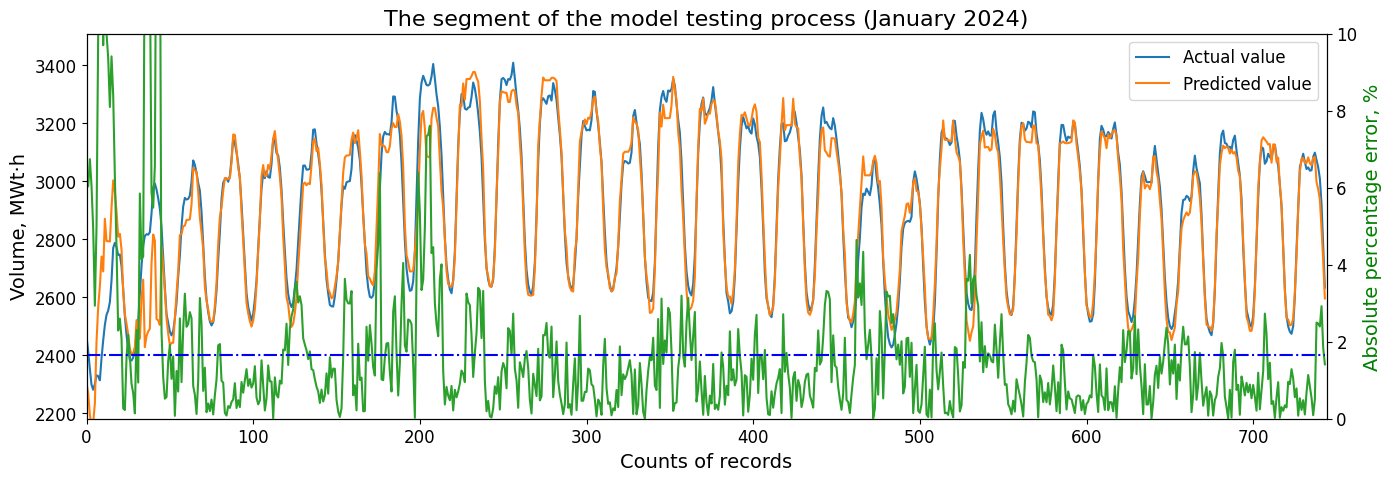

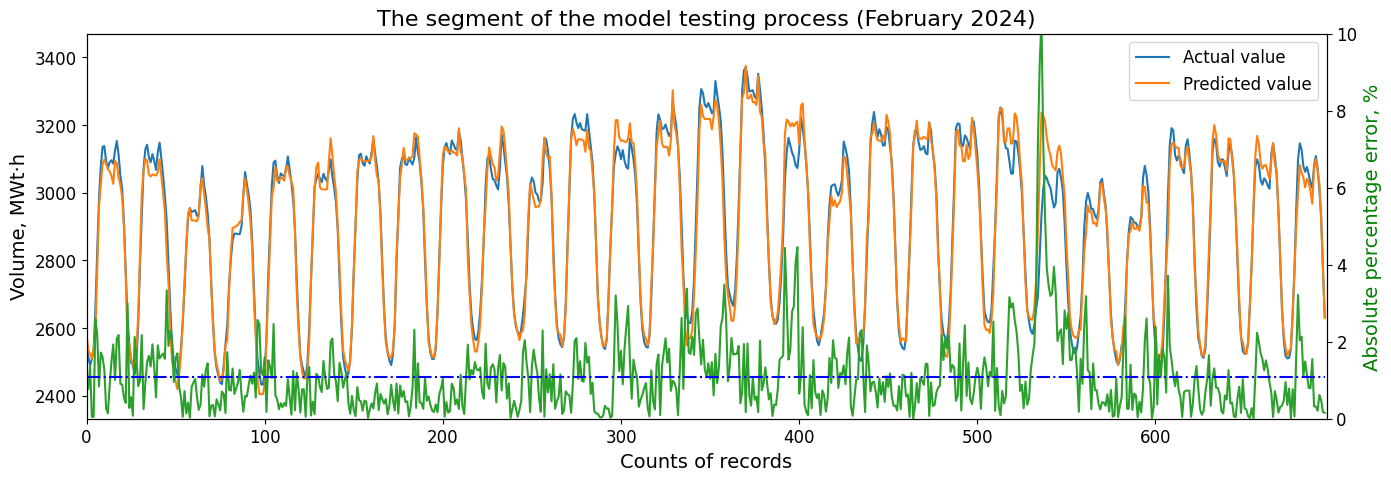

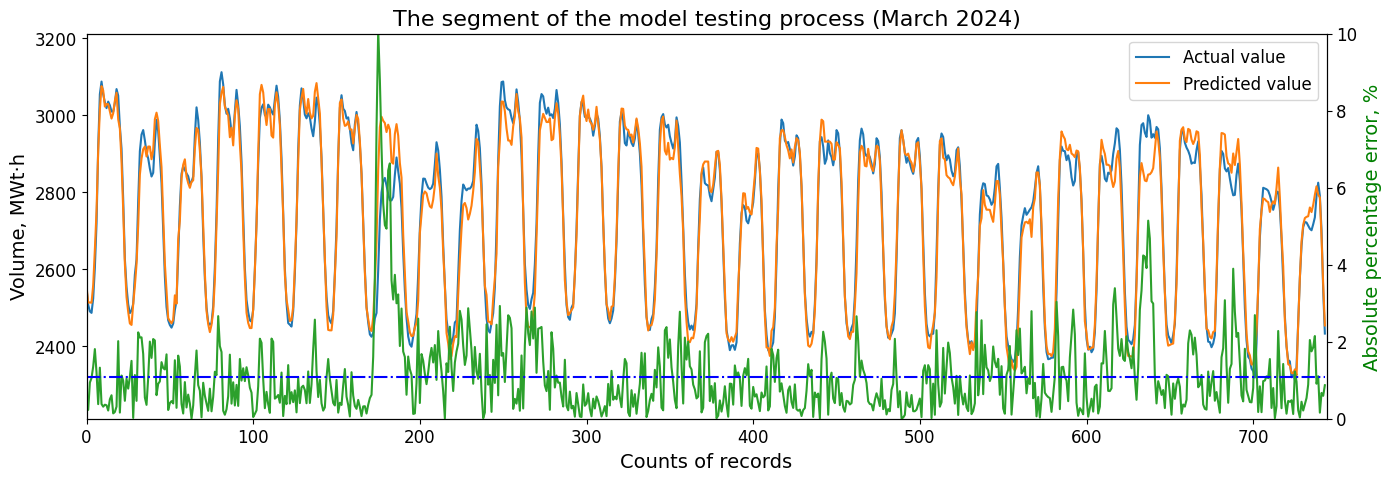

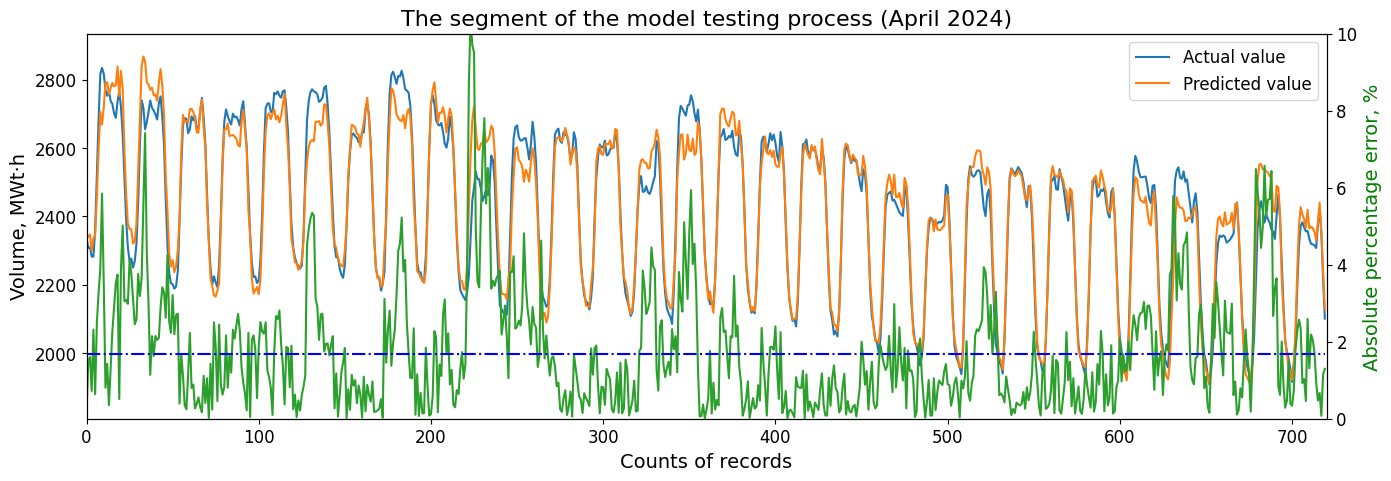

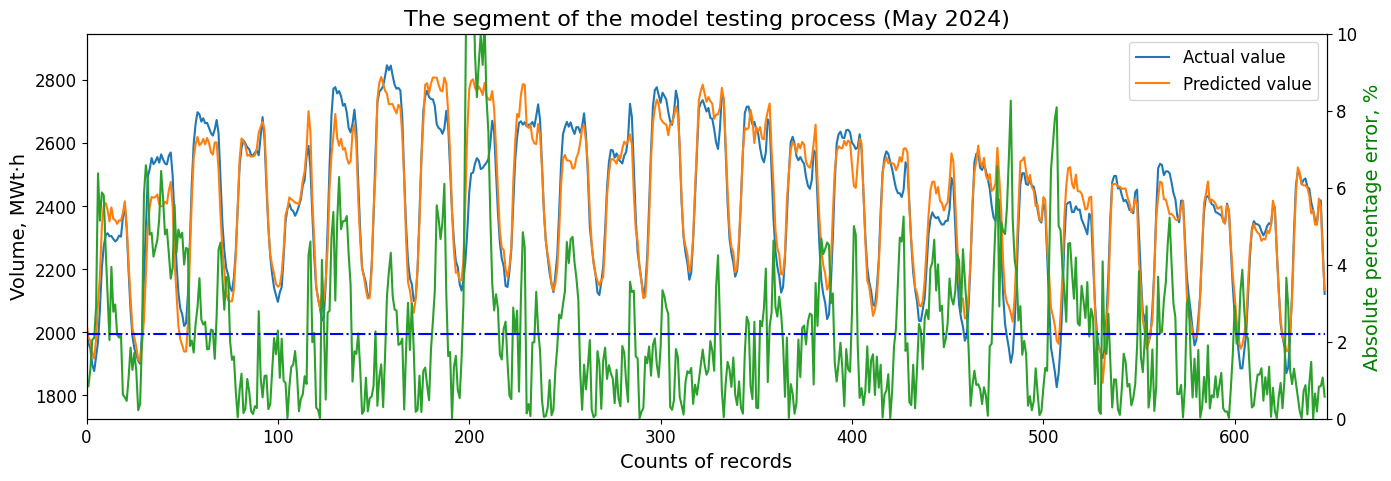

In [303]:
diff_predict_vs_fact(df_validate_result, 1)
diff_predict_vs_fact(df_validate_result, 2)
diff_predict_vs_fact(df_validate_result, 3)
diff_predict_vs_fact(df_validate_result, 4)
diff_predict_vs_fact(df_validate_result, 5)